# Assignment 3: Classification to Segmentation

<!-- 이번 선택 과제에서는 필수 과제 1에서 classification 문제를 풀기 위해 구성했던 VGG-11을 **segmentation 문제를 풀기 위한 모델**로 재구성해보는 과정을 진행합니다. 모델에서 layer들을 구성하는 모듈들이 동작하는 방식을 더 잘 이해하는 시간이 되셨으면 좋겠습니다. -->

이번 과제에서는 VGG-11을 **segmentation 문제를 풀기 위한 모델**로 재구성해보는 과정을 진행합니다. 

과제 목표
- 모델에서 layer들을 구성하는 모듈들이 동작하는 방식을 더 잘 이해하는 시간이 되셨으면 좋겠습니다.
- Classification에서부터 초기 segmentation모델로 발전하는 발전사를 이해할 수 있는 시간이 되셨으면 좋겠습니다.
- 네트워크에 저장된 파라메터를 자유자재로 reshaping해서 활용하면서 같은 연산을 다르게 볼 수 있는 융통성 있는 시각을 가질 수 있도록 합시다.


##**Data Download**
해당 문제를 풀기 위해서는 (1) pretrained model 과 (2) 저희가 선별한 inference용도의 data가 따로 필요합니다. 아래의 명령어를 통해 과제 해결에 필요한 파일들을 colab session에 다운로드하고 압축을 해제해주세요.

    
**Inference를 위해 사용하는 data에는 저작권 문제가 있으니, 과제 해결 이외의 작업에는 절대로 사용하시면 안됩니다. 본 과제는 캠프 교육용 라이선스 (대외 노출 금지) 입니다.**

In [1]:
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC" -O files.zip && rm -rf ~/cookies.txt

--2022-03-08 04:59:08--  https://docs.google.com/uc?export=download&confirm=t&id=1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC
Resolving docs.google.com (docs.google.com)... 142.250.207.14, 2404:6800:4004:820::200e
Connecting to docs.google.com (docs.google.com)|142.250.207.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hrpv5n5riq8o0v4r8t2dceg32dmcb6ms/1646715525000/09977954582062536659/*/1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC?e=download [following]
--2022-03-08 04:59:09--  https://doc-10-3g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hrpv5n5riq8o0v4r8t2dceg32dmcb6ms/1646715525000/09977954582062536659/*/1zpOLZ-iJLSUvjaemYoI7hE_CdsW0rKEC?e=download
Resolving doc-10-3g-docs.googleusercontent.com (doc-10-3g-docs.googleusercontent.com)... 172.217.175.65, 2404:6800:4004:81e::2001
Connecting to doc-10-3g-docs.googleusercontent.com (doc-10-3g-docs.goo

In [2]:
!unzip files.zip

Archive:  files.zip
  inflating: data/mask3.jpg          
  inflating: data/normal.jpg         
  inflating: data/mask5.jpg          
  inflating: data/incorrect_mask.jpg  
  inflating: data/mask2.jpg          
  inflating: data/mask4.jpg          
  inflating: data/mask1.jpg          
  inflating: model.pth               


## **VGG-11 Implementation**


Image classification을 위해 학습된 VGG-11를 semantic segmentation를 해결하기 위한 모델로 변경하는 것이 목표입니다. 이 과제에서 핵심은 **마지막 fully connected layer를 1x1 convolution layer**로 변경하여, 픽셀별로 분류 문제를 수행하는 모델로 변경하는 것입니다. Semantic segmentation이 이미지 하나에 대해 (image-level) classification하는 것이 아니라 각 픽셀 별로 (pixel-level) classification을 수행하는 것임을 잊지 마세요 :)

Classification을 위하여 사용하였던 마지막 fully connected layer는 convolution backbone을 통해 얻은 feature map을 펼친 다음 (flatten) 연산을 진행하기 때문에 입력 이미지의 공간 정보(spatial information)를 유지하지 못합니다. 따라서 fully connected layer를 1x1 convolution으로 바꾸면 공간 정보를 유지하며 segmentation을 수행할 수 있습니다. 또한 fc layer의 weights는 hidden_dim X num_classes이고, 1x1 convolution의 weights는 hidden_dim X 1 X 1의 크기를 갖는 convolution filter를 num_classes개 만큼 사용하므로 전체 parameter의 개수는 갖습니다. 따라서 classification을 위해 학습된 fully connected layer의 weights를 적절히 reshaping하여 1x1 convolution filter의 weights로 사용하면 해당 모델을 바로 segmentation model로 변환할 수 있습니다. 

FCN [1]으로 알려진 fully convolutional network는 위와 같은 아이디어를 이용하여 semantic segmentation을 수행한 논문입니다.


<img src='https://paperswithcode.com/media/methods/new_alex-model.jpg'  width="500">


[[1] Long et al, Fully Convolutional Networks for Semantic Segmentation, CVPR 2015](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)

### Model

아래 3가지 클래스에 대한 설명입니다.

-  **(1) VGG11BackBone**: VGG-11의 backbone에 해당하는 코드입니다.
- **(2) VGG11Classification**: **(1) VGG11Backbone**의 출력값을 받아 global average pooling을 거친 다음 fully connected를 통과시켜 최종 classification을 수행하는  코드입니다.
- **(3) VGG11Segmentation**: **(1) VGG11Backbone**의 출력값을 받아 1x1 convolution을 통과시켜 semantic segmentation을 수행하는 코드입니다. 이때, **(2) VGG11Classification**의 fully connected layer의 weights를 가져와 1x1 convolution filter의 weights 값으로 사용하고자 **copy_last_layer** 모듈을 호출합니다. 해당 과제에서는 **copy_last_layer**의 코드를 완성하는 것이 목표입니다.


위에서 설명한 3개의 클래스 기반으로 아래의 2가지 **TO DO**를 완성해주세요.


- **TO DO (1)**: Semantic segmentation을 수행하기 위한 layer의 code를 작성해주세요. (Hint: **forward** method의 코드)

- **TO DO (2)**: **fc_out** 레이어의 parameter를 적절히 reshape하고 segmentation을 위해 작성한 layer에 copy해주세요.

- **Hint**: 아래의 코드를 활용해보세요 :)   
(1) layer.weight (layer의 weights 값을 Tensor로 얻는 과정, [참고 자료](https://stackoverflow.com/questions/56435961/how-to-access-the-network-weights-while-using-pytorch-nn-sequential))\
(2) torch.reshape    
(3) torch.nn.Conv2d    
(4) torch.nn.Parameter

In [3]:
import torch
import torch.nn as nn

class VGG11BackBone(nn.Module):
  '''
  VGG-11의 backbone에 해당하는 부분입니다.
  총 8개의 convolution layer로 구성되어 있습니다.
  '''
  def __init__(self):
    super(VGG11BackBone, self).__init__()

    self.relu = nn.ReLU(inplace=True)
    
    # Convolution Feature Extraction Part
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.bn1   = nn.BatchNorm2d(64)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn2   = nn.BatchNorm2d(128)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.bn3_1   = nn.BatchNorm2d(256)
    self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    self.bn3_2   = nn.BatchNorm2d(256)
    self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.bn4_1   = nn.BatchNorm2d(512)
    self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn4_2   = nn.BatchNorm2d(512)
    self.pool4   = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_1   = nn.BatchNorm2d(512)
    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.bn5_2   = nn.BatchNorm2d(512)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.bn3_1(x)
    x = self.relu(x)
    x = self.conv3_2(x)
    x = self.bn3_2(x)
    x = self.relu(x)
    x = self.pool3(x)

    x = self.conv4_1(x)
    x = self.bn4_1(x)
    x = self.relu(x)
    x = self.conv4_2(x)
    x = self.bn4_2(x)
    x = self.relu(x)
    x = self.pool4(x)

    x = self.conv5_1(x)
    x = self.bn5_1(x)
    x = self.relu(x)
    x = self.conv5_2(x)
    x = self.bn5_2(x)
    x = self.relu(x)

    return x

In [4]:
class VGG11Classification(nn.Module):
  def __init__(self, num_classes = 7):
    '''
    VGG-11의 classifier에 해당하는 부분입니다.
    VGG11BackBone의 출력값을 받아 max pooling - global average pooling - fully connected를 통과하여 최종 prediction logits를 출력합니다.
    '''
    super(VGG11Classification, self).__init__()

    self.backbone = VGG11BackBone()
    self.pool5   = nn.MaxPool2d(kernel_size=2, stride=2)
    self.gap      = nn.AdaptiveAvgPool2d(1)
    self.fc_out   = nn.Linear(512, num_classes)

  def forward(self, x):
    x = self.backbone(x)
    x = self.pool5(x)
    x = self.gap(x)
    x = torch.flatten(x, 1)
    x = self.fc_out(x)

    return x

In [53]:
class VGG11Segmentation(nn.Module):
  def __init__(self, num_classes = 7):
    '''
    VGG-11를 재구성하여 semantic segmentation을 해결하기 위한 모델에 해당하는 부분입니다.
    VGG11BackBone의 출력값을 받아 1x1 convolution을 통과하여 픽셀별 classification을 수행한 다음,
    max pooling으로 인하여 줄어든 resolution을 bilinear upsampling을 통해 입력 이미지의 크기로 확장합니다.
    '''
    super(VGG11Segmentation, self).__init__()

    self.backbone = VGG11BackBone()
    
    '''==========================================================='''
    '''======================== TO DO (1) ========================'''

    with torch.no_grad():
      self.conv_out = nn.Conv2d(512, 7, kernel_size=1)

    '''======================== TO DO (1) ========================'''
    '''==========================================================='''
  
    self.upsample = torch.nn.Upsample(scale_factor=16, mode='bilinear', align_corners=False)


  def forward(self, x):
    x = self.backbone(x)
    x = self.conv_out(x)
    x = self.upsample(x)
    assert x.shape == (1, 7, 224, 224)

    return x


  def copy_last_layer(self, fc_out):
    """
    VGG-11 classifier의 마지막 fully-connected layer인 'fc_out'을 입력으로 받아,
    해당 'fc_out'의 weights를 __init__에서 구현한 1x1 convolution filter의 weights로 copy하는 method입니다.

    Keyword arguments:
    fc_out: the fc layer of classification model (with shape of (7, 512))
    """

    '''==========================================================='''
    '''======================== TO DO (2) ========================'''
    
    reshaped_fc_out = fc_out.weight
    reshaped_fc_out = torch.reshape(reshaped_fc_out, shape=(7,512,1,1))
    self.conv_out.weight = torch.nn.Parameter(reshaped_fc_out)

    '''======================== TO DO (2) ========================'''
    '''==========================================================='''
    assert self.conv_out.weight[0][0] == fc_out.weight[0][0]
    
    return 

In [54]:
'''
Classification 모델과 segmentation의 모델의 output shape을 확인할 시간입니다.

Classification 모델은 각 class에 대한 logit을 예측하므로 (batch_size, num_classes)의 shape을 가집니다.
Segmentation 모델은 각 channel이 하나의 class에 대한 값을 가지므로 입력 이미지의 크기와 동일한 logit map (batch_size, num_classes, height, width)의 shape을 가집니다.

test_input은 batch_size가 1이고 input resolution이 224 x 224인 Tensor입니다.
아래의 코드를 실행하여 segmentation model의 출력 크기가 정확한지 확인해보세요.
'''
test_input = torch.randn((1, 3, 224, 224))

modelC = VGG11Classification()
out = modelC(test_input)
print('The output shape of the classification network:', out.shape)

modelS = VGG11Segmentation()
out = modelS(test_input)
print('The output shape of the segmentation network:', out.shape)

The output shape of the classification network: torch.Size([1, 7])
The output shape of the segmentation network: torch.Size([1, 7, 224, 224])


### Dataloader

In [55]:
# Dataset
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import os
import cv2
import numpy as np
from glob import glob

class MaskDataset(Dataset):
  def __init__(self, data_root, input_size=224, transform=None):
    super(MaskDataset, self).__init__()

    self.img_list = glob(os.path.join(data_root, '*.jpg'))
    self.len = len(self.img_list)
    self.input_size = input_size
    self.transform = transform

  def __getitem__(self, index):
    img_path = self.img_list[index]
  
    # Image Loading
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.

    if self.transform:
      img = self.transform(img)

    # Ground Truth
    label = self._get_class_idx_from_img_name(img_path)

    return img, label
  def __len__(self):
    return self.len
  
  def _get_class_idx_from_img_name(self, img_path):
    img_name = os.path.basename(img_path)

    if 'normal' in img_name:
      return 0
    elif 'mask1' in img_name:
      return 1
    elif 'mask2' in img_name:
      return 2
    elif 'mask3' in img_name:
      return 3
    elif 'mask4' in img_name:
      return 4
    elif 'mask5' in img_name:
      return 5
    elif 'incorrect_mask' in img_name:
      return 6
    else:
      raise ValueError("%s is not a valid filename. Please change the name of %s." % (img_name, img_path))

## Weight Reshaping

### Loading model

Mask dataset에 대해 이미 학습된 classification VGG-11을 불러오는 과정입니다.

In [56]:
## Model Loading
model_root = './model.pth'

modelC = VGG11Classification()
modelC.load_state_dict(torch.load(model_root))

<All keys matched successfully>

### Copy weight to reshape

앞에서 구현한 copy_last_layer을 이용하여 modelC (classification network)의 마지막 fully connected layer인 fc_out의 weights를 modelS (segmentation entwork)의 1x1 convolution layer로 copy하는 부분입니다.

In [57]:
# Init segmentation network
modelS  = VGG11Segmentation()

# Copy the backbone of classification to segmentation backbone
modelS.backbone = modelC.backbone

# Copy the weights of the fc layer to 1x1 conv layer of segmentation network
fc_out = modelC.fc_out
modelS.copy_last_layer(fc_out)

### Test

아래는 주어진 샘플 이미지에 대한 segmentation 결과를 시각화하는 과정입니다.

첨부 그림은 예시 이미지 하나에 대해 결과를 시각화한 것입니다. 결과를 보시면 알 수 있듯이 classification 모델을 segmentation 모델로 재구성함에 따라 해당 모델이 각 영역을 어떻게 판단하고 있는지를 확인할 수 있습니다. 마스크 데이터셋을 통해 수행한 분류 문제가 해당 인물이 마스크를 어떤 타입으로 착용하고 있는지를 구분하는 것이었으므로 마스크 주위에 segmentation 결과가 집중되어 있습니다.

추가로 정확히 마스크의 영역을 잡아내고 있지는 않은데 이는 마스크 영역에 해당하는 픽셀별 ground truth가 주어지지 않았기 때문이며 또한 입력 이미지에 비해 16분의 1 사이즈의 feature map에서 픽셀별 예측을 진행하고 단순히 bilinear interpolation을 진행했기 때문입니다. 어떻게 하면 해당 segmentation network의 성능을 더 끌어올릴 수 있을지 고민해보세요 :)

<img src='https://drive.google.com/uc?id=1IFw0QT2zbr1txEQXaTBGuRGtgXBm8ruP'  width="224">

In [58]:
# Image Loading
data_root = './data'
input_size = 224
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
batch_size = 1

test_dataset = MaskDataset(data_root, input_size=input_size, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

<ipython-input-61-535ac19727b2>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  [segR, segC] = np.where(seg == np.int(label[0].cpu()))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


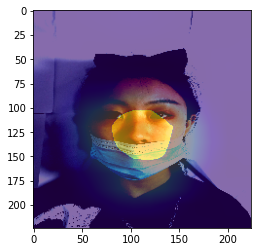

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


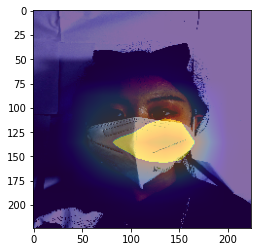

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


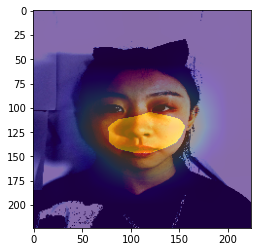

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


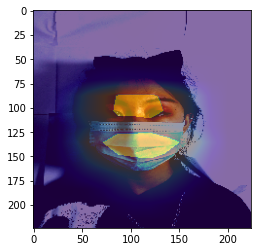

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


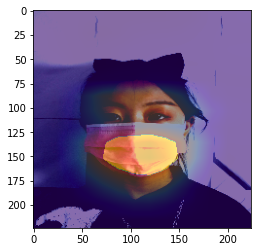

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


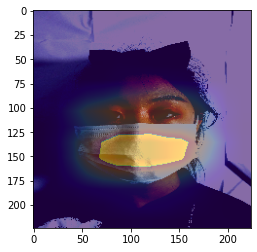

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


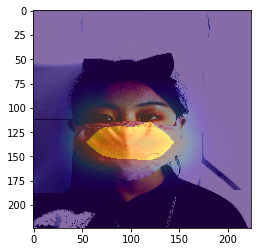

In [61]:
import matplotlib
import matplotlib.pyplot
# Test on Segmentation
modelS.cuda().float()
modelS.eval()

for iter, (img, label) in enumerate(test_loader):
  img = img.float().cuda()
  
  # Inference for Semantic Segmentation
  res = modelS(img)[0]

  heat = res[label[0]]
  resH = heat.cpu().detach().numpy()
  heatR, heatC = np.where(resH > np.percentile(resH, 95))
  
  seg = torch.argmax(res, dim=0)
  seg = seg.cpu().detach().numpy()
  [segR, segC] = np.where(seg == np.int(label[0].cpu()))

  resS = np.zeros((224,224))
  for i, r in enumerate(heatR):
    c = heatC[i]
    if (r in segR) and (c in segC):
      resS[r,c] = 1
  
  want_to_check_heat_map_result = True

  # Plot segmentation result
  matplotlib.pyplot.imshow(img[0].cpu().permute(1, 2, 0))
  if want_to_check_heat_map_result:
    matplotlib.pyplot.imshow(resH, cmap='jet', alpha=0.3)
  matplotlib.pyplot.imshow(resS, alpha=0.4)
  matplotlib.pyplot.show()

#### **Disccusion**

- **want_to_check_heat_map_result** flag를 True로 설정하여 추가로 heatmap을 확인해보세요. 해당 과정을 통해 모델의 출력값을 그대로 시각화할 수 있습니다!

- Segmentation이라고 했지만, 막상 heatmap에 가깝고 정확하게 Segmentation이 안되는 결과가 나온 것 같습니다. 좀 더 Segmentation 답게 만들기 위해서는 어떤 것들을 추가적으로 해야할지 고민해보시기 바랍니다.

- 본 과제는 심화과제1 - CNN visualization과 밀접한 연관성을 가지고 기획/설계되었습니다. 추후 심화과제1도 확인해보시기 바랍니다.